In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_squared_error
from util.evaluation import SMAPE
%matplotlib inline

traffic=pd.read_csv('../data/cl_traffic.csv')

traffic=traffic.fillna(0)

traffic.head()

In [222]:
sample_index=np.random.choice(traffic.index,1000,replace=False)
sample_series=[]
for u in sample_index:
#     print('Training...|| {:.2f}'.format(u/tot_len*100)+'%',end='\r')
    sample_series.append(traffic.loc[u][:-4].values)

def diff(x,epsilon=1e-3):
    return((x[1:]-x[:-1])/(x[:-1]+epsilon))

## prepare training and testing data

In [162]:
def split_and_clean(sample_series,train_start,train_end,test_len):
    clean_series=[]
    test_series=[]
    for index in range(len(sample_series)):
        c=np.array(sample_series[index][train_start:train_end])
        test_series.append(sample_series[index][train_end:(train_end+test_len)])
        std=np.std(c)
        mean=np.mean(c)
        c[(c-np.mean(c))>2*std]=mean+2*std
        c[(c-np.mean(c))<-2*std]=mean-2*std
        clean_series.append(c)
    return (clean_series,test_series)

In [163]:

def normalize_X(clean_series):
    recover_dic={}
    scaled_series=[]
    for i in range(len(clean_series)):
        if np.sum(clean_series[i])==0:
            scaled_series.append(np.zeros_like(clean_series[i]))
            recover_dic[i]=(0,0)
        else:
            std=np.std(clean_series[i])
            biased_mean=np.mean(clean_series[i])-3*std

            recover_dic[i]=(std,biased_mean)
            new_series=clean_series[i]-biased_mean
            new_series[new_series<0]=0
            new_series=new_series/(6*std)
            new_series[new_series>1]=1
            scaled_series.append(new_series)
    return (scaled_series,recover_dic)


def normalize_Y(clean_series,recover_dic):
    scaled_series=[]
    for i in range(len(clean_series)):
        (std,biased_mean) = recover_dic[i]
        
        if std==0:
            # ignore all zero cases
#             print(clean_series[i])
            scaled_series.append(np.zeros_like(clean_series[i]))

        else:
            

            new_series=clean_series[i]-biased_mean
            new_series[new_series<0]=0
            new_series=new_series/(6*std)
            new_series[new_series>1]=1
            scaled_series.append(new_series)
    return (scaled_series)

def recover(scaled_series,recover_dic):
    recovered_series=[]
    for i in range(len(scaled_series)):
        std,biased_mean=recover_dic[i]
        new_series=scaled_series[i]*(6*float(std))+biased_mean
        recovered_series.append(new_series)
    return recovered_series

In [23]:
# encode_start=0
# encode_end=150
# decode_len=63

# clean_series,decode_series = split_and_clean(sample_series,encode_start,encode_end,decode_len)


# train_x=clean_series
# train_y=decode_series

# encode_start=200
# encode_end=350
# decode_len=63


# clean_series,decode_series = split_and_clean(sample_series,encode_start,encode_end,decode_len)

# test_x=clean_series
# test_y=decode_series

In [223]:
encode_start=0
encode_end=150
decode_len=63

clean_series,decode_series = split_and_clean(sample_series,encode_start,encode_end,decode_len)
train_x,train_dic = normalize_X(clean_series)
train_y = normalize_Y(decode_series,train_dic)


encode_start=200
encode_end=350
decode_len=63

PERIOD=7

clean_series,decode_series = split_and_clean(sample_series,encode_start,encode_end,decode_len)

test_x,test_dic = normalize_X(clean_series)
test_y = normalize_Y(decode_series,test_dic)

In [25]:
# train_x[0]

In [165]:
def make_one_hots(length,last_pointer=-1):
    pointer=(last_pointer+1) % PERIOD
#     print(pointer)
    one_hots=[]
    one_hot_temp=np.zeros(PERIOD)
    for i in range(length):
        one_hot=one_hot_temp.copy()
        one_hot[pointer]=1
        one_hots.append(one_hot)
        pointer+=1
        pointer=pointer % PERIOD
    return np.array(one_hots)

In [8]:
# trainx=X_loader(train_x,batch_size)

# a,b=next(trainx)

# a.size()


In [9]:
# b[:,2:3,:],b[:,2:3,:]

In [10]:
# b[:,2:3,:]*b[:,2:3,:]

In [27]:
def X_loader(x,batchsize):
    batch=0
    x=np.array(x,dtype=np.float32)
#     x=np.log(x+1)
    one_hots=make_one_hots(len(x[0]))
    
    while batch<(len(x) // batchsize):
        
        data=x[batch*batchsize:(batch+1)*batchsize,:]
        tensor=torch.FloatTensor(np.array(data, dtype=float))
        tensor=tensor.unsqueeze(2).cuda()
        
        feature=torch.FloatTensor(np.array(one_hots)).unsqueeze(0)
        feature=feature.expand((batchsize,feature.size()[1],feature.size()[2])).cuda()
        
        yield(tensor,feature)
        batch+=1

In [28]:

def Y_loader(y,batchsize,length_x):
    batch=0
    y=np.array(y,dtype=np.float32)
#     y=np.log(y+1)
    last_pointer=length_x % PERIOD - 1
    one_hots=make_one_hots(len(y[0]),last_pointer)
    while batch<(len(y) // batchsize):
        
        data=y[batch*batchsize:(batch+1)*batchsize,:]
        tensor=torch.FloatTensor(np.array(data, dtype=float))
        tensor=tensor.unsqueeze(2).cuda()

        feature=torch.FloatTensor(np.array(one_hots)).unsqueeze(0)
        feature=feature.expand((batchsize,feature.size()[1],feature.size()[2])).cuda()
        
        yield(tensor,feature)
        batch+=1

In [29]:
import torch
import torch.nn as nn


In [14]:
# for name, param in decoder.named_parameters():
#     if param.requires_grad:
#         print (name, param.data)

In [226]:
def SMAPE(true,predicted):
    true=true.squeeze()
    predicted=predicted.squeeze()
#     true=torch.exp(true)-1
#     predicted=torch.exp(predicted)-1
    epsilon = 0.1
    summ = torch.abs(true) + torch.abs(predicted) + epsilon
    smape = torch.abs(predicted - true) / summ * 2.0
    return torch.mean(smape)

In [227]:
from torch import optim
from numpy import random as random
epoch=190
indicator=5

# optimizer = optim.RMSprop(model.parameters(), lr=0.001, alpha=0.99, \
#     eps=1e-08, weight_decay=0, momentum=0, centered=False)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0)
input_size=PERIOD
hidden_size=PERIOD
output_size=1
lr=0.01
batch_size=10
encoder=EncoderRNN(input_size,hidden_size,output_size).cuda() if use_cuda else EncoderRNN(1,hidden_size)
decoder=DecoderRNN(input_size,hidden_size,output_size).cuda() if use_cuda else DecoderRNN(1,hidden_size)
teacher_forcing_ratio = 0.4
encoder_optimizer = optim.SGD(encoder.parameters(), lr=lr)
decoder_optimizer = optim.SGD(decoder.parameters(), lr=lr)

In [229]:
# ps,_,score = valid_iter(test_x, test_y)
# for kk in range(12):
#     plt.plot(ps[kk][:21])
#     plt.title('epoch '+str(0))
# plt.show()
# print("Validation! Epoch: {}; Loss: {}\n".format(-1, np.mean(score)))
for i in range(epoch):
    
    trainx=X_loader(train_x,batch_size)
    trainy=Y_loader(train_y,batch_size,len(train_x[0]))
    
    running_loss_e = 0.0
    running_loss_d = 0.0
#     validation(test_x,test_y)
    for j,(X_batch,x_feature) in enumerate(trainx):
        #Parse loaded batch
        x=X_batch
        y,y_feature=next(trainy)
        
        e_loss,d_loss=train(x, x_feature, y, y_feature, encoder, decoder, encoder_optimizer, \
                  decoder_optimizer, SMAPE)
        running_loss_e += e_loss
        running_loss_d += d_loss
        if (j>0) and (j % indicator == 0):
            print("Epoch: {}; iterations: {}; encoding Loss: {};decoding Loss: {}\n".format(i, j, \
                                running_loss_e / indicator,running_loss_d / indicator))
            running_loss_e = 0.0
            running_loss_d = 0.0
        
    ps,_,score,_ = valid_iter(test_x, test_y)
#     for kk in range(1):
#         plt.plot(ps[kk][:21])
#         plt.title('epoch '+str(i))
#     plt.show()
    print("Validation! Epoch: {}; Loss: {}\n".format(i, np.mean(score)))

Epoch: 0; iterations: 5; encoding Loss: 0.3157834046639052;decoding Loss: 0.3154807832505968

Epoch: 0; iterations: 10; encoding Loss: 0.21869122806011426;decoding Loss: 0.2256704890538776

Epoch: 0; iterations: 15; encoding Loss: 0.2644022538357933;decoding Loss: 0.24854909503270708

Epoch: 0; iterations: 20; encoding Loss: 0.24842175733323063;decoding Loss: 0.3122525442214239

Epoch: 0; iterations: 25; encoding Loss: 0.2633025457395003;decoding Loss: 0.22116166372147816

Epoch: 0; iterations: 30; encoding Loss: 0.2596967889158518;decoding Loss: 0.30261319478352866

Epoch: 0; iterations: 35; encoding Loss: 0.2464022694018063;decoding Loss: 0.18992711173163518

Epoch: 0; iterations: 40; encoding Loss: 0.24532915665799343;decoding Loss: 0.2524217514764695

Epoch: 0; iterations: 45; encoding Loss: 0.26064473094556156;decoding Loss: 0.29178172520228796

Epoch: 0; iterations: 50; encoding Loss: 0.25892300701781407;decoding Loss: 0.27194272298661487

Epoch: 0; iterations: 55; encoding Loss:

Epoch: 4; iterations: 45; encoding Loss: 0.2625378090263213;decoding Loss: 0.25175947764563184

Epoch: 4; iterations: 50; encoding Loss: 0.2605697529427958;decoding Loss: 0.20176959870353578

Epoch: 4; iterations: 55; encoding Loss: 0.2745281757124318;decoding Loss: 0.20231925722152466

Epoch: 4; iterations: 60; encoding Loss: 0.25954810020907615;decoding Loss: 0.2416428005884564

Epoch: 4; iterations: 65; encoding Loss: 0.2878520735158216;decoding Loss: 0.26498734307667565

Epoch: 4; iterations: 70; encoding Loss: 0.2464974883418755;decoding Loss: 0.21082446688697454

Epoch: 4; iterations: 75; encoding Loss: 0.27273458954471874;decoding Loss: 0.22435556139264787

Epoch: 4; iterations: 80; encoding Loss: 0.25193490662030726;decoding Loss: 0.24047791011749756

Epoch: 4; iterations: 85; encoding Loss: 0.2603564217586645;decoding Loss: 0.21634859660315137

Epoch: 4; iterations: 90; encoding Loss: 0.28457840273044255;decoding Loss: 0.2334869142562624

Epoch: 4; iterations: 95; encoding Los

KeyboardInterrupt: 

In [230]:
preds,targets,scores,es=valid_iter(test_x,test_y)

In [354]:
# scores

In [103]:
testx=X_loader(test_x,batchsize=128)
testy=Y_loader(test_y,batchsize=128,length_x=len(test_x[0]))


In [375]:
a=next(testx)
b=next(testy)

In [297]:
a[1][0,-3:,:]

tensor([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  1.,  0.,  0.,  0.,  0.]], device='cuda:0')

In [300]:
b[1][0,:5,:]

tensor([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  1.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  1.],
        [ 1.,  0.,  0.,  0.,  0.,  0.,  0.]], device='cuda:0')

In [32]:
targets[:,:8]

array([[0.45962387, 0.46120766, 0.44457787, ..., 0.46569508, 0.4678068 ,
        0.4564563 ],
       [0.46780175, 1.        , 0.6438196 , ..., 0.46780175, 0.46396485,
        0.44717842],
       [0.27315187, 0.27315187, 0.3995788 , ..., 0.33636534, 0.27315187,
        0.20993839],
       ...,
       [0.45992765, 0.55347604, 0.7405727 , ..., 0.5690674 , 0.64702433,
        0.5690674 ],
       [0.4457808 , 0.39468357, 0.4457808 , ..., 0.5479753 , 0.39468357,
        0.4457808 ],
       [0.45295188, 0.3764918 , 0.2982274 , ..., 0.3503285 , 0.3861903 ,
        0.4058128 ]], dtype=float32)

In [105]:
for i in range(488,500):
    print(preds[i,-7:])

[0.2571519  0.2500574  0.2391514  0.23001522 0.22230694 0.21386938
 0.26386854]
[0.23585773 0.22919711 0.21922274 0.21122189 0.20402688 0.19941661
 0.24262346]
[0.5107236  0.5008164  0.48334423 0.47034907 0.45651424 0.4410268
 0.51438195]
[0.1901192  0.18434757 0.17586353 0.1691934  0.16346745 0.16044654
 0.19637816]
[0.26265186 0.2555004  0.2444066  0.23679422 0.23031329 0.22551228
 0.26979095]
[0.3547201  0.34620768 0.33245504 0.32029304 0.30809045 0.30169386
 0.3613777 ]
[0.2675631  0.26035416 0.2505476  0.24116157 0.2343021  0.2270195
 0.27450332]
[0.22953387 0.22296529 0.21288612 0.20523107 0.1996957  0.19589369
 0.23637345]
[0.24915254 0.24220134 0.2312095  0.22269973 0.21557283 0.20881085
 0.25597727]
[0.16277915 0.1576295  0.14974408 0.14378092 0.13991311 0.13874805
 0.16861853]
[0.20015427 0.19416074 0.1846981  0.17746527 0.17245485 0.17081954
 0.20669302]
[6.3306513e-30 6.0704063e-30 1.0450329e-29 9.8752705e-30 9.2133818e-30
 8.3744775e-30 6.6153504e-30]


In [104]:
preds[1656,2::7]

array([0.49913087, 0.42983168, 0.3800393 , 0.34540197, 0.32188746,
       0.30620098, 0.29586273, 0.28910494, 0.28471163], dtype=float32)

In [97]:
# from util.evaluation import SMAPE as cpu_SMAPE
# scores=[]
# for (t,p) in zip(truth,pred):
#     scores.append(cpu_SMAPE(t,p))

In [98]:
# np.mean(scores)

In [233]:
preds=recover(preds,test_dic)
recovered_test_x=recover(test_x,test_dic)
targets=recover(targets,test_dic)
es=recover(es,test_dic)

In [234]:
from util.evaluation import SMAPE as cpu_SMAPE
mean_scores=[]


for ID in range(40):

    pred=preds[ID]
    truth=targets[ID]
    scores=[]
    for (t,p) in zip(truth,pred):
        scores.append(cpu_SMAPE(t,p))

    mean_scores.append(np.mean(scores))
np.mean(mean_scores)

0.5853802792583328

In [240]:
# es

[46.90461  46.31186  45.54164  44.58914  43.37297  40.740234 46.158302
 45.60148  45.016396 44.255898 43.320457 42.130096 39.565857 46.003784
 45.44771  44.86354  44.104202 43.17079  41.98349  39.427353 45.98552
 45.429535 44.845474 44.086273 43.1531   41.966164 39.41098  45.983353
 45.427376 44.84333  44.084145 43.151    41.964104 39.409035 45.9831
 45.427124 44.84307  44.083893 43.15075  41.963867 39.408813 45.983078
 45.4271   44.84305  44.08387  43.150734 41.963844 39.40879  45.98307
 45.427094 44.84304  44.083862 43.15072  41.963837 39.408783 45.98307
 45.427094 44.84304  44.083862 43.15072  41.963837 39.408783 45.98307 ]


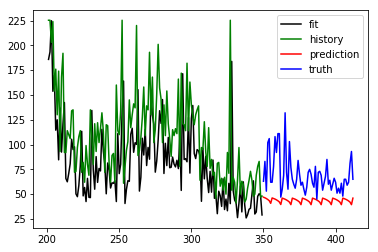

In [244]:
ID=12
# source=sample_series[ID][encode_start:encode_end]
source=recovered_test_x[ID]
pred=preds[ID]
truth=targets[ID]
print(pred)
# for i in range(10):
plt.figure()
plt.plot(np.arange(encode_start+1,encode_end),es[ID][:-1],color='black',label='fit')
plt.plot(np.arange(encode_start+1,encode_end),source[1:],color='g',label='history')
plt.plot(np.arange(encode_end,encode_end+decode_len),pred,color='r',label='prediction')
plt.plot(np.arange(encode_end,encode_end+decode_len),truth,color='b',label='truth')
plt.legend()

In [225]:
def valid_iter(test_x,test_y):
    testx=X_loader(test_x,batchsize=10)
    testy=Y_loader(test_y,batchsize=10,length_x=len(test_x[0]))

    preds=[]
    targets=[]
    e_outs=[]
    scores=[]
    for j,(X_batch,x_feature) in enumerate(testx):
        #Parse loaded batch
        print(j,end='\r')
        target,y_feature=next(testy)

    
        score,out,e_out = valid(X_batch,x_feature, target,y_feature, encoder, decoder, SMAPE)
        out=out.T
        scores.append(score)
        target=target.squeeze().detach().cpu().numpy()
        if j ==0:
            preds=out
            targets=target
            e_outs=e_out
        else:
            preds=np.concatenate((preds,out),axis=0)
#             print(preds.shape)
            e_outs=np.concatenate((e_outs,e_out),axis=0)
            targets=np.concatenate((targets,target),axis=0)
    return (preds,targets,scores,e_outs)

In [369]:
# preds
import numpy

def sigmoid(x):
    return 1 / (1 + numpy.exp(-x))
sigmoid(0.)

0.5

In [368]:
sigmoid(0.6)

0.6456563062257954

In [45]:
np.tanh(0.3)

0.2913126124515909

In [26]:
a,b=torch.rand(2,2),torch.rand(2,1)


In [23]:
b=b.expand(b.size(0),a.size(1))

tensor([[ 0.8679,  0.8679],
        [ 0.2422,  0.2422]])

In [24]:
a

tensor([[ 0.5509,  0.5657],
        [ 0.8888,  0.3870]])

In [89]:
torch.sigmoid(nn.init.xavier_uniform_(torch.empty(2,2)))

tensor([[ 0.5690,  0.5119],
        [ 0.7148,  0.2448]])

In [143]:
class SRU(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SRU, self).__init__()
        self.hidden_size = hidden_size
        self.input_size=input_size
        self.forget_w = nn.Linear(input_size, hidden_size,bias=True)
        self.out_w = nn.Linear(hidden_size, hidden_size,bias=True)
    def forward(self, Input, hidden):
        #input size: is
        #batch size: bs
        #hidden size: hs
        
        #input:(bs,is)
        #hidden:(bs,hs)
        
        #(bs,hs)
        Z=torch.sigmoid(self.forget_w(Input))
        #(bs,hs)
        new_hidden=Z*Input+(1-Z)*hidden
        O=torch.sigmoid(self.out_w(Input))
        output=O*new_hidden+(1-O)*Input
        return new_hidden,output

In [151]:
use_cuda=True
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size,output_size):
        super(EncoderRNN, self).__init__()

        self.hidden_size = hidden_size
#         self.gru = nn.GRU(input_size, hidden_size, batch_first=True, bidirectional=False)
#         self.rnnc = nn.RNNCell(input_size, hidden_size, bias=True, nonlinearity='relu')
        self.rnnc = SRU(input_size, hidden_size)
#         self.out = nn.Linear(hidden_size, output_size)
    def forward(self, input_x,feature, hidden):
        #batchsize: bs
        #feature size: fs
        #hidden_size: hs(=bs)
        #input_x:(bs,1)
        #feature:(bs,fs)
        #hidden:(bs,1,hs)
        
        input_x=input_x.expand(input_x.size(0),feature.size(1))
        #(bs,fs)
        rnn_input=input_x*feature
        #(bs,hs)(bs,hs)
        hidden,output = self.rnnc(rnn_input, hidden)
        #(bs,hs)
#         hidden = output
        #(bs,1)
        output = torch.sum(feature*output,1,keepdim=True)
        #(bs,1,1)
#         output = torch.sigmoid(output)
         #(bs,1),(bs,hs)
        return output, hidden

    def initHidden(self,b_size):
        
#         nn.init.xavier_normal_(self.out)
        paras= torch.sigmoid(nn.init.xavier_normal_(torch.empty(b_size,self.hidden_size))).cuda() if use_cuda else \
                torch.sigmoid(nn.init.xavier_normal_(torch.empty(b_size,self.hidden_size)))
        return paras

class DecoderRNN(nn.Module):
    def __init__(self, input_size,hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
#         self.gru = nn.GRU(input_size, hidden_size, batch_first=True, bidirectional=False)
#         self.rnnc = nn.RNNCell(input_size, hidden_size, bias=True, nonlinearity='relu')
        self.rnnc = SRU(input_size, hidden_size)
#         self.out = nn.Linear(hidden_size, output_size)
    def forward(self, input_x,feature, hidden):
        #batchsize: bs
        #feature size: fs
        #hidden_size: hs(=bs)
        #input_x:(bs,1)
        #feature:(bs,fs)
        #hidden:(bs,1,hs)
        
        input_x=input_x.expand(input_x.size(0),feature.size(1))
        #(bs,fs)
        rnn_input=input_x*feature
        #(bs,hs)(bs,hs)
        hidden,output = self.rnnc(rnn_input, hidden)
        #(bs,hs)
#         hidden = output
        #(bs,1)
        output = torch.sum(feature*output,1,keepdim=True)
        #(bs,1,1)
#         output = torch.sigmoid(output)
         #(bs,1),(bs,hs)
        return output, hidden

#     def initHidden(self,b_size):
        
# #         nn.init.xavier_normal_(self.out)
#         paras= nn.init.xavier_normal_(torch.empty(b_size,self.hidden_size)).cuda() if use_cuda else \
#                 nn.init.xavier_normal_(torch.empty(b_size,self.hidden_size))
#         return paras



def train(input_variable, input_feature, target_variable, target_feature, encoder, decoder, encoder_optimizer, \
          decoder_optimizer, criterion):
    encoder.train()
    decoder.train()
    encoder_hidden = encoder.initHidden(input_variable.size(0))

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_variable.size()[1]
    target_length = target_variable.size()[1]
    
#     encoder_outputs = torch.zeros(input_length, encoder.hidden_size)
#     encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs
   
    loss_encoding = 0

    for ei in range(input_length-1):

        encoder_output, encoder_hidden = encoder(
            input_variable[:,ei,:],input_feature[:,ei,:], encoder_hidden)
        loss_encoding += criterion(encoder_output.squeeze(),input_variable[:,ei+1,:].squeeze())
#         encoder_outputs[ei] = encoder_output[0,0,:]
#     print('-'*90)
#     print('pred')
#     print(encoder_output.size())
#     print(encoder_output)
#     print('target')
#     print(input_variable[:,ei+1:(ei+2),:].size())
#     print(input_variable[:,ei+1:(ei+2),:])
#     print(criterion(encoder_output.squeeze(),input_variable[:,ei+1:(ei+2),:].squeeze()))
#     print('-'*90)
    #get the first prediction
    encoder_output, encoder_hidden = encoder(input_variable[:,ei+1,:],input_feature[:,ei+1,:],\
                                             encoder_hidden)
    decoder_input = encoder_output
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input
    
    decoder_hidden = encoder_hidden
#     print(input_variable[:,-1,:])
#     print(decoder_hidden)
#     print('_'*90)
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    loss_decoding=0
    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
#             print(decoder_hidden.size())
#             decoder_output, decoder_hidden = decoder(
#                 decoder_input,target_feature[:,di:(di+1),:], decoder_hidden)
        
            
            decoder_output, decoder_hidden = decoder(
                decoder_input,target_feature[:,di,:], encoder_hidden)
        
            loss_decoding += criterion(decoder_output.squeeze(), target_variable[:,di,:].squeeze())
            decoder_input = target_variable[:,di,:]  # Teacher forcing

    else:
#         print('real start')
#         print(input_variable[:,ei:(ei+1),:])
#         print('encode start')
#         print(decoder_input)
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            
#             print(decoder_hidden.size())
#             decoder_output, decoder_hidden = decoder(
#                 decoder_input,target_feature[:,di:(di+1),:], decoder_hidden)
        
            
            decoder_output, decoder_hidden = decoder(
                decoder_input,target_feature[:,di,:], encoder_hidden)

            
            decoder_input = decoder_output
            decoder_input = decoder_input.cuda() if use_cuda else decoder_input
#             print('sizes')
#             print(decoder_output.size(),target_variable[:,di:di+1,:].size())
#             print('pred')
#             print(decoder_output)
#             print('truth')
#             print(target_variable[:,di:di+1,:])
#             print('-'*90)
            loss_decoding += criterion(decoder_output.squeeze(), target_variable[:,di,:].squeeze())
#     loss=loss_encoding+loss_decoding
    loss=loss_decoding
    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return ((loss_encoding.item() / (input_length-1)),(loss_decoding.item() / target_length))

In [206]:
def valid(input_variable, input_feature, target_variable, target_feature, encoder, decoder, criterion):
    encoder.eval()
    decoder.eval()
    encoder_hidden = encoder.initHidden(input_variable.size(0))
    
    input_length = input_variable.size()[1]
    target_length = target_variable.size()[1]
#     print(target_length)
    
    loss = 0
    encoder_outputs=[]
    for ei in range(input_length):

        encoder_output, encoder_hidden = encoder(
            input_variable[:,ei,:],input_feature[:,ei,:], encoder_hidden)
        encoder_outputs.append(encoder_output.squeeze().detach().cpu().numpy())
    decoder_input = encoder_output
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input
    
    decoder_hidden = encoder_hidden

#     use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

#     if use_teacher_forcing:
#         # Teacher forcing: Feed the target as the next input
#         for di in range(target_length):
#             decoder_output, decoder_hidden = decoder(
#                 decoder_input, decoder_hidden)
#             loss += criterion(decoder_output, target_variable[:,di:di+1,:])
#             decoder_input = target_variable[:,di:di+1,:]  # Teacher forcing

#     else:
        # Without teacher forcing: use its own predictions as the next input
    outputs=[]
#     print('!'*90)
    for di in range(target_length):
#         decoder_output, decoder_hidden = decoder(
#             decoder_input,target_feature[:,di:(di+1),:], decoder_hidden)


        decoder_output, decoder_hidden = decoder(
            decoder_input,target_feature[:,di,:], encoder_hidden)
#         print('-'*90)
#         print('in',decoder_input.size())
#         print('in',target_feature.size())
#         print('hidden',encoder_hidden.size())
#         print('out',decoder_hidden.size())
        
        
#         print('in',decoder_input[0,:])
#         print('in',target_feature[0,di,:])
#         print('hidden',decoder_hidden[0,:])
#         print('out',decoder_hidden[0,:])
#         print('out',decoder_output[0,:])
        
#         decoder_output, decoder_hidden = decoder(
#         decoder_input*10,target_feature[:,di,:], encoder_hidden)
        
#         print('in',decoder_input[0,:]*10)
#         print('in',target_feature[0,di,:])
#         print('hidden',encoder_hidden[0,:])
#         print('out',decoder_hidden[0,:])
#         print('out',decoder_output[0,:])
        
        
        
#         decoder_output, decoder_hidden = decoder(
#         decoder_input+0.2,target_feature[:,di,:], encoder_hidden)
        
#         print('in',decoder_input[0,:]+0.2)
#         print('in',target_feature[0,di,:])
#         print('hidden',encoder_hidden[0,:])
#         print('out',decoder_hidden[0,:])
#         print('out',decoder_output[0,:])
        
        
        decoder_input = decoder_output
        decoder_input = decoder_input.cuda() if use_cuda else decoder_input
        outputs.append(decoder_output.squeeze().detach().cpu().numpy())
#         print(decoder_output.size(), target_variable[:,di:di+1,:].size())
#         print(decoder_output.size(), target_variable[:,di:di+1,:].size())
        loss += criterion(decoder_output, target_variable[:,di:di+1,:])


    return (loss.item() / target_length,np.array(outputs),np.array(encoder_outputs).T)

In [40]:
preds[0]

array([0.        , 0.67977846, 0.58159673, 0.13477805, 0.3376326 ,
       0.2360518 , 0.        , 0.        , 0.67977846, 0.58159673,
       0.13477805, 0.3376326 , 0.2360518 , 0.        , 0.        ,
       0.67977846, 0.58159673, 0.13477805, 0.3376326 , 0.2360518 ,
       0.        , 0.        , 0.67977846, 0.58159673, 0.13477805,
       0.3376326 , 0.2360518 , 0.        , 0.        , 0.67977846,
       0.58159673, 0.13477805, 0.3376326 , 0.2360518 , 0.        ,
       0.        , 0.67977846, 0.58159673, 0.13477805, 0.3376326 ,
       0.2360518 , 0.        , 0.        , 0.67977846, 0.58159673,
       0.13477805, 0.3376326 , 0.2360518 , 0.        , 0.        ,
       0.67977846, 0.58159673, 0.13477805, 0.3376326 , 0.2360518 ,
       0.        , 0.        , 0.67977846, 0.58159673, 0.13477805,
       0.3376326 , 0.2360518 , 0.        ], dtype=float32)

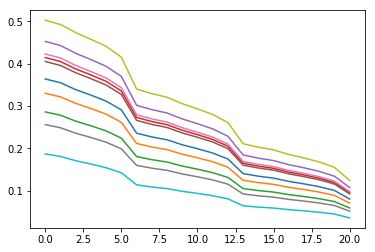

In [131]:
for i in range(10):
    plt.plot(preds[i][:21])
#     plt.plot(targets[i][:21])
#     plt.plot(preds[213])

In [58]:
preds

[]

In [211]:
preds,targets,scores,e_outs=valid_iter(test_x,test_y)

In [213]:
e_outs

array([0.44304785, 0.4536797 , 0.86116034, 0.27382272, 0.4177227 ,
       0.69456244, 0.44599217, 0.5233862 , 0.4533701 , 0.69911   ,
       0.32287702, 0.2533988 , 0.31656727, 0.33595887, 0.676985  ,
       0.5884136 , 0.40683138, 0.32299232, 0.46273628, 0.31543434,
       0.33415386, 0.53788435, 0.4533303 , 0.40683138, 0.26453546,
       0.19963416, 0.31541297, 0.33431128, 0.22599581, 0.3873194 ,
       0.47975534, 0.5009159 , 0.5137249 , 0.43364638, 0.1822842 ,
       0.3006333 , 0.7444258 , 0.3340225 , 0.3233326 , 0.5143423 ,
       0.25784174, 0.33235478, 0.3049815 , 0.7305932 , 0.3340225 ,
       0.56118965, 0.2535761 , 0.6165943 , 0.28325692, 0.36795396,
       0.589715  , 0.40683138, 0.32344946, 0.30629858, 0.20128748,
       0.3335596 , 0.5887382 , 0.6588124 , 0.47975534, 0.2645284 ,
       0.46283102, 0.37385076, 0.38557556, 0.23317325, 0.45379943,
       0.40683138, 0.4411164 , 0.3067714 , 0.55511886, 0.28394857,
       0.43370736, 0.7295621 , 0.40683138, 0.14915657, 0.46285

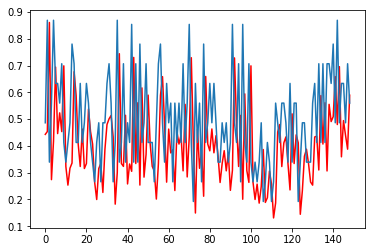

In [221]:
plt.plot(e_outs[:-1],color='r')
plt.plot(test_x[0][1:])

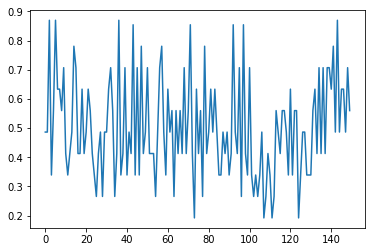